In [1]:
import os
from itertools import repeat
from concurrent.futures import ThreadPoolExecutor
from geotile import GeoTile
import geopandas as gpd
import rasterio
from shapely.geometry import Polygon
import shapely

In [8]:
!ls images/tif

J-29-C-2-O-9.tif  J-29-C-4-N-9.tif  J-29-C-5-M-9.tif  J-29-C-5-O-1.tif
J-29-C-2-P-4.tif  J-29-C-4-P-3.tif  J-29-C-5-N-1.tif  J-29-C-5-O-2.tif
J-29-C-2-P-5.tif  J-29-C-5-M-2.tif  J-29-C-5-N-2.tif  J-29-C-5-O-3.tif
J-29-C-2-P-6.tif  J-29-C-5-M-3.tif  J-29-C-5-N-3.tif  J-29-C-5-P-1.tif
J-29-C-2-P-7.tif  J-29-C-5-M-4.tif  J-29-C-5-N-4.tif  J-29-C-6-M-1.tif
J-29-C-2-P-8.tif  J-29-C-5-M-5.tif  J-29-C-5-N-5.tif  J-29-C-6-M-4.tif
J-29-C-2-P-9.tif  J-29-C-5-M-6.tif  J-29-C-5-N-6.tif  masks
J-29-C-3-O-7.tif  J-29-C-5-M-7.tif  J-29-C-5-N-7.tif  tiles
J-29-C-4-N-6.tif  J-29-C-5-M-8.tif  J-29-C-5-N-8.tif


In [3]:
def tile_image(input_image, output_path):
        gt = GeoTile(input_image)
        image_name = os.path.basename(input_image)
        prefix = image_name.replace('.tif', '_')
        gt.generate_tiles(
            output_path,
            tile_x=1024,
            tile_y=1024,
            stride_x=1024,
            stride_y=1024,
            prefix=prefix
        )


def tiles_from_path(input_path, output_path, debug: bool = False):
    input_images = [img for img in os.listdir('images/tif') if img.endswith('.tif')]
    
    if debug:
        input_images = input_images[:12]

    try:
        print(f'Processing {len(input_images)} images...')

        input_images_path = [os.path.join(input_path, img) for img in input_images]

        with ThreadPoolExecutor(max_workers=12) as executor:
            futures = list(executor.map(
                tile_image,
                input_images_path,
                repeat(output_path)
            ))
        print('Processing complete.')
        
    except Exception as e:
        print('Failed processing: ', e)

In [4]:
input_path = 'images/tif'
output_path = 'images/tif/tiles/'

tiles_from_path(input_path, output_path, False)

Processing 33 images...
Processing complete.


## Borra tiles fuera de AOI train

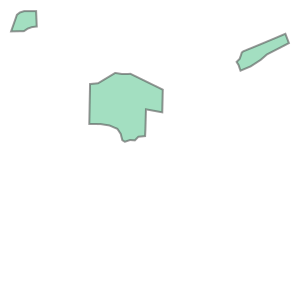

In [5]:
# borra tiles que no solapan con el área de entrenamiento
aoi_train = gpd.read_file("input_vector_data/aoi_train.geojson")

# Get list of geometries for all features in vector file
geom_list = [shapes for shapes in aoi_train.geometry]

aoi_geom = shapely.unary_union(geom_list)

aoi_geom

In [6]:
input_images = os.listdir('images/tif/tiles')
input_images[:3]

['J-29-C-6-M-1_95.tif', 'J-29-C-5-M-6_41.tif', 'J-29-C-5-P-1_18.tif']

In [7]:
counter = 0

for img in input_images:
    img_path = os.path.join('images/tif/tiles', img)
    raster = rasterio.open(img_path)
    coords = [raster.bounds[i] for i in range(4)]
    lon_point_list = [coords[0], coords[2], coords[2], coords[0]]
    lat_point_list = [coords[3], coords[3], coords[1], coords[1]]
    bbox = Polygon(zip(lon_point_list, lat_point_list))

    if not bbox.intersects(aoi_geom):
        print('No hay intersección entre AOI e imagen input.')
        os.remove(img_path) 
    else:
        counter += 1
        print(f'Se conserva el tile {img}')

No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e im

No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e imagen input.
No hay intersección entre AOI e im

RasterioIOError: 'images/tif/tiles/train' not recognized as a supported file format.

In [ ]:
counter